In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from pymongo import MongoClient
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
import pymysql


# CNN
from keras.layers.convolutional import Conv1D

# RNN
from keras.layers.recurrent import LSTM


In [5]:
maxlen = 500
max_words=200
n_epochs = 6

In [6]:
engine = create_engine('')

In [7]:
save_scores = []

In [22]:

# client = MongoClient("localhost:27017")
# db=client.indv
# result=db.cleanreviews.find({})
# source=list(result)
# df = pd.DataFrame(source)

In [8]:
df = pd.read_sql_table('labeled', engine)
df = df[:10000]

In [9]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [10]:
X = []
sentences = list(df['Review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [184]:
df['Label']

0       Positive
1       Negative
2       Positive
3       Positive
4       Positive
          ...   
9995    Negative
9996    Negative
9997    Negative
9998    Negative
9999    Negative
Name: Label, Length: 10000, dtype: object

In [11]:
y = df['Label']

y = np.array(list(map(lambda x: 1 if x=="Positive" else 0, y)))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)


In [15]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
vocab_size = len(tokenizer.word_index) + 1

In [189]:
vocab_size

8704

In [190]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [116]:
# create the model
# Sequential kan lineare lagen van opnemen dus de .add() function heeft dit model speciaal
model = Sequential()
# Eerste laag van onze neuraal netwerk heeft een input_dim, output_dum en input_lenght
# de input_dim defined het aantal neurons/nodes dus hoeveel woorden hij kan hebben
# output_dum = 32
# input_length is lengte van de input moet unfirom zijn in de Train en test data
model.add(Embedding(vocab_size, 32, input_length=maxlen))
# 
model.add(Flatten())
model.add(Dense(250, activation='relu'))
# 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 32)           111904    
_________________________________________________________________
flatten_4 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 250)               4000250   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 251       
Total params: 4,112,405
Trainable params: 4,112,405
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
# Fit the model
history=model.fit(X_train, y_train, batch_size=128, epochs=n_epochs, verbose=1, validation_split=0.2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", scores[0])
print("Test Accuracy:", scores[1])


Epoch 1/6
5/5 [==============================] - 1s 93ms/step - loss: 0.4584 - accuracy: 0.5759 - val_loss: 0.3477 - val_accuracy: 0.8938
Epoch 2/6
5/5 [==============================] - 0s 53ms/step - loss: 0.2656 - accuracy: 0.9204 - val_loss: 0.2938 - val_accuracy: 0.8938
Epoch 3/6
5/5 [==============================] - 0s 56ms/step - loss: 0.2431 - accuracy: 0.9215 - val_loss: 0.2849 - val_accuracy: 0.8938
Epoch 4/6
5/5 [==============================] - 0s 56ms/step - loss: 0.2331 - accuracy: 0.9154 - val_loss: 0.2495 - val_accuracy: 0.9062
Epoch 5/6
5/5 [==============================] - 0s 58ms/step - loss: 0.2041 - accuracy: 0.9288 - val_loss: 0.2328 - val_accuracy: 0.9062
Epoch 6/6
7/7 [==============================] - 0s 6ms/step - loss: 0.1684 - accuracy: 0.9300
Test Score: 0.16840657591819763
Test Accuracy: 0.9300000071525574


In [ ]:
score

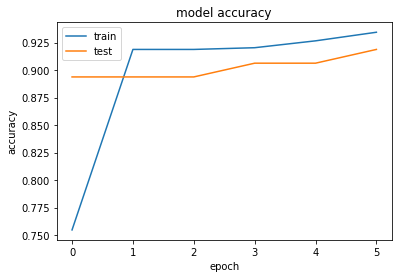

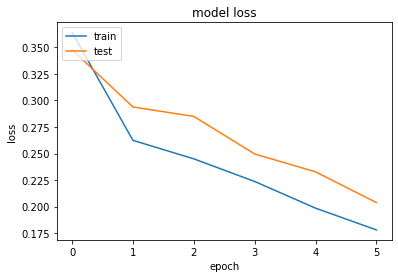

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [68]:
# Convelutional ///////////

# create the model
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=maxlen))
    #  text is 1 dimensional, so Conv1D
    #  the kernel in this case is a vector of length 5, not a 2 dimensional matrix
model.add(Conv1D(128, 5, activation='relu'))
    #  the pooling layer in this case is also 1 dimensional
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 32)           112736    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 496, 128)          20608     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 133,473
Trainable params: 133,473
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
# Run convelutional
history = model.fit(X_train, y_train, batch_size=128, epochs=n_epochs, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/6
5/5 [==============================] - 1s 198ms/step - loss: 0.6590 - accuracy: 0.9250 - val_loss: 0.6050 - val_accuracy: 0.8938
Epoch 2/6
5/5 [==============================] - 1s 148ms/step - loss: 0.5817 - accuracy: 0.9036 - val_loss: 0.5293 - val_accuracy: 0.8938
Epoch 3/6
5/5 [==============================] - 1s 149ms/step - loss: 0.5008 - accuracy: 0.9041 - val_loss: 0.4524 - val_accuracy: 0.8938
Epoch 4/6
5/5 [==============================] - 1s 157ms/step - loss: 0.4171 - accuracy: 0.9107 - val_loss: 0.3873 - val_accuracy: 0.8938
Epoch 5/6
5/5 [==============================] - 1s 156ms/step - loss: 0.3315 - accuracy: 0.9264 - val_loss: 0.3475 - val_accuracy: 0.8938
Epoch 6/6
7/7 [==============================] - 0s 9ms/step - loss: 0.2998 - accuracy: 0.9100
Test Score: 0.2997909486293793
Test Accuracy: 0.9100000262260437


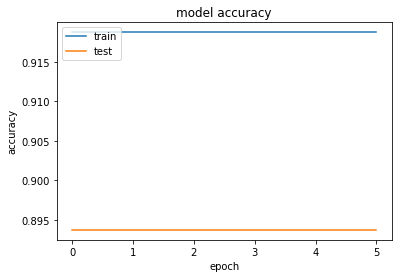

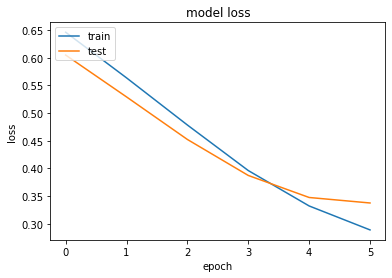

In [70]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [71]:
# Reccurent neural network

# create the model
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=maxlen))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 32)           112736    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 195,297
Trainable params: 195,297
Non-trainable params: 0
_________________________________________________________________
None


In [72]:
# Run Reccurent

history = model.fit(X_train, y_train, batch_size=128, epochs=n_epochs, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/6
5/5 [==============================] - 7s 985ms/step - loss: 0.6823 - accuracy: 0.5540 - val_loss: 0.6111 - val_accuracy: 0.8938
Epoch 2/6
5/5 [==============================] - 4s 881ms/step - loss: 0.5420 - accuracy: 0.9271 - val_loss: 0.3648 - val_accuracy: 0.8938
Epoch 3/6
5/5 [==============================] - 4s 846ms/step - loss: 0.2818 - accuracy: 0.9273 - val_loss: 0.3938 - val_accuracy: 0.8938
Epoch 4/6
5/5 [==============================] - 4s 850ms/step - loss: 0.3323 - accuracy: 0.9091 - val_loss: 0.3390 - val_accuracy: 0.8938
Epoch 5/6
5/5 [==============================] - 4s 865ms/step - loss: 0.2714 - accuracy: 0.9248 - val_loss: 0.3391 - val_accuracy: 0.8938
Epoch 6/6
7/7 [==============================] - 1s 84ms/step - loss: 0.3026 - accuracy: 0.9100
Test Score: 0.3026241362094879
Test Accuracy: 0.9100000262260437


7/7 [==============================] - 1s 72ms/step - loss: 0.3026 - accuracy: 0.9100


[0.3026241362094879, 0.9100000262260437]

In [218]:
model = Sequential()
# Turns positive integers (indexes) into dense vectors of fixed size. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
model.add(Embedding(vocab_size, 32, input_length=maxlen))
# 2e laag heeft 256 nodes/neurons
model.add(Dense(256, activation='relu'))
# output geactiveerd door een sigmoid functie als output voor classificaties
model.add(Dense(1, activation='sigmoid'))
# loss = binary want het is een binart classificatie
# optimizer adam =
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 500, 32)           278528    
_________________________________________________________________
dense_34 (Dense)             (None, 500, 256)          8448      
_________________________________________________________________
dense_35 (Dense)             (None, 500, 1)            257       
Total params: 287,233
Trainable params: 287,233
Non-trainable params: 0
_________________________________________________________________
None


In [215]:
history = model.fit(X_train, y_train, batch_size=128, epochs=n_epochs, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/6
50/50 [==============================] - 8s 149ms/step - loss: 0.5289 - accuracy: 0.9897 - val_loss: 0.0671 - val_accuracy: 0.9925
Epoch 2/6
50/50 [==============================] - 7s 144ms/step - loss: 0.0624 - accuracy: 0.9898 - val_loss: 0.0440 - val_accuracy: 0.9925
Epoch 3/6
50/50 [==============================] - 7s 142ms/step - loss: 0.0470 - accuracy: 0.9918 - val_loss: 0.0440 - val_accuracy: 0.9925
Epoch 4/6
50/50 [==============================] - 7s 141ms/step - loss: 0.0578 - accuracy: 0.9895 - val_loss: 0.0440 - val_accuracy: 0.9925
Epoch 5/6
50/50 [==============================] - 7s 144ms/step - loss: 0.0518 - accuracy: 0.9908 - val_loss: 0.0441 - val_accuracy: 0.9925
Epoch 6/6
63/63 [==============================] - 1s 14ms/step - loss: 0.0462 - accuracy: 0.9920
Test Score: 0.046233221888542175
Test Accuracy: 0.9919999837875366


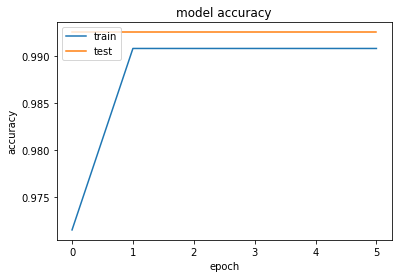

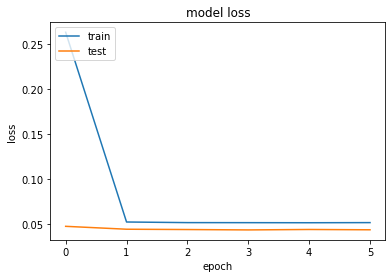

In [196]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [216]:
pred = model.predict(X_test, batch_size=128, verbose=1)

16/16 [==============================] - 1s 58ms/step


In [204]:
rounded_pred = np.argmax(pred, axis = 1)

In [227]:
zuwed = []
pred = model.predict(X_test).round()

In [234]:
y_test[6]

0